# Chain animation
Analyse cosmological model posterior samples.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.5' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)

from functools import partial
from getdist import plots
from numpyro import infer

%matplotlib inline
%load_ext autoreload
%autoreload 2

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

## Load

In [3]:
from montecosmo.mcbench import Chains
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme, SetDark2

save_dir = '/feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_ao0.5_evlpt_lo1_pckaiser_obfield/'
save_path = save_dir + 'sMCLMC_nc4_ns64'

# Load truth
print(f"Loading truth from {save_dir}")
truth = pload(save_dir+"truth.p")
model = FieldLevelModel(**default_config)
mesh0 = jnp.fft.irfftn(truth['init_mesh'])
pow0 = model.spectrum(mesh0)
kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)
start = 2
end = 3

# Load chains
thinning = 1
transforms = [
            lambda x: x[['*~diverging']],
            partial(Chains.thin, thinning=thinning), 
            model.reparam_chains, 
            partial(model.powtranscoh_chains, mesh0=mesh0),
            # partial(Chains.choice, n=10, names=['init','init_']),
            ]
chains = model.load_runs(save_path, start, end, transforms=transforms, batch_ndim=2)
print(chains.shape)

Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_ao0.5_evlpt_lo1_pckaiser_obfield/


2025-02-24 11:13:46.795205: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Loading: sMCLMC_nc4_ns64, from run 2 to run 3 (included)
{'Omega_m': (4, 128), 'b1': (4, 128), 'b2': (4, 128), 'bn2': (4, 128), 'bs2': (4, 128), 'init_mesh': (4, 128, 64, 64, 64), 'kptc': ((4, 128, 15), (4, 128, 15), (4, 128, 15), (4, 128, 15)), 'mse_per_dim': (4, 128), 'n_evals': (4, 128), 'sigma8': (4, 128)}


In [2]:
from montecosmo.mcbench import Chains
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_trans, plot_coh, theme, SetDark2

save_dir = '/feynman/home/dphp/hs276503/scratch/pickles/init/'
save_path = save_dir + 'sMCLMC_nc8_ns32'

# Load truth
print(f"Loading truth from {save_dir}")
truth = pload(save_dir+"truth.p")
model = FieldLevelModel.load(save_dir+"model.p")
mesh0 = jnp.fft.irfftn(truth['init_mesh'])
pow0 = model.spectrum(mesh0)
kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)

init = pload(save_path+'_init_state.p')
init_last = pload(save_path+'_init_last_state.p').position
last0 = pload(save_path+'_0_last_state.p').position
last = pload(save_path+'_last_state.p').position

pth  = "/feynman/home/dphp/hs276503/scratch/pickles/evolution/m128_b640.0_ao0.5_evlpt_lo2_pckaiser_dyn_obfield/sMCLMC_nc8_ns32_chains.p"
chains = pload(pth)
kptcs_last = tree.map(jnp.concatenate, chains)['kptc']

Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/init/


2025-03-25 15:39:56.417883: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
################
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme
mesh0 = jnp.fft.irfftn(truth['init_mesh'])
kptcs__ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init)
kptcs_ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init | init_last)
kptcs = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(last)
kptcs0 = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(last0)
# kpk0 = model.spectrum(mesh0)
# kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)
# kpkobs = model.spectrum(truth['obs']-1)

print(init.keys(), init_last.keys(), last.keys())

dict_keys(['Omega_m_', 'b1_', 'b2_', 'bn2_', 'bs2_', 'init_mesh_', 'sigma8_']) dict_keys(['init_mesh_']) dict_keys(['Omega_m_', 'b1_', 'b2_', 'bn2_', 'bs2_', 'init_mesh_', 'sigma8_'])


In [4]:
from montecosmo.bricks import lin_power_interp, get_cosmology, lin_power_mesh
cosmo = get_cosmology(**model.loc_fid)
# powmesh = lin_power_mesh(cosmo, model.mesh_shape, model.box_shape)
# mesh = jnp.fft.rfftn(jr.normal(jr.key(0), model.mesh_shape))
# mesh = jnp.fft.irfftn(mesh * powmesh**.5)
# kptcs_fiduc = model.powtranscoh(mesh0, mesh)

pow_fn = lin_power_interp(cosmo)
fiduc_trans = np.array((pow_fn(pow0[0]) / pow0[1])**.5)
trans = jnp.median(jnp.stack(kptcs_), 1)[2]
for i in range(15):
    fiduc_trans[i] = (fiduc_trans[i] - trans[i] ) / (15-i) * 3  + trans[i]
fiduc_trans = pow0[0], fiduc_trans

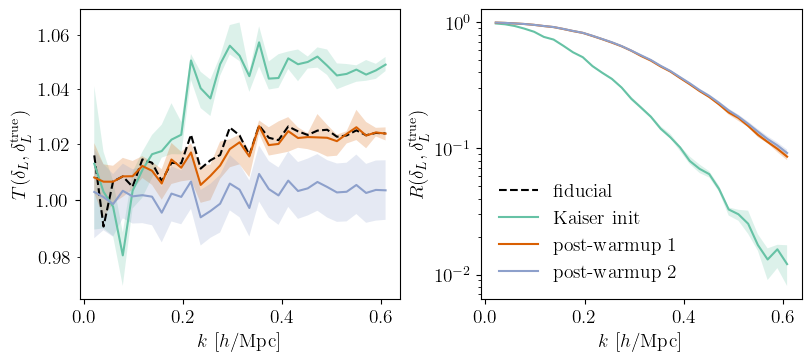

In [8]:
theme(usetex=True, font_size=14)
prob = 0.95
plt.figure(figsize=(8, 3.5), layout='constrained')
plt.subplot(121)
kptcs__med = jnp.median(jnp.stack(kptcs__), 1)
kptcs_med = jnp.median(jnp.stack(kptcs_), 1)
kptcs_last_med = jnp.median(jnp.stack(kptcs_last), 1)

plot_trans(*fiduc_trans, 'k--', label='fiduc')
plot_trans(kptcs__med[0], kptcs__med[2], label='Kaiser init')
plot_trans(kptcs__[0], kptcs__[2], fill=prob)
plot_trans(kptcs_med[0], kptcs_med[2], label='post warmup 1')
plot_trans(kptcs_[0], kptcs_[2], fill=prob)
plot_trans(kptcs_last_med[0], kptcs_last_med[2], label='post warmup 2')
plot_trans(kptcs_last[0], kptcs_last[2], fill=prob)

import matplotlib as mpl
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())

plt.ylabel('$T(\\delta_L, \\delta_L^\\mathrm{true})$')

plt.subplot(122)
plt.plot((), 'k--', label='fiducial')
plot_coh(kptcs__med[0], kptcs__med[3], label='Kaiser init')
plot_coh(kptcs__[0], kptcs__[3], fill=prob)
plot_coh(kptcs_med[0], kptcs_med[3], label='post-warmup 1')
plot_coh(kptcs_[0], kptcs_[3], fill=prob)
plot_coh(kptcs_last_med[0], (kptcs_last_med[3] - 1) * 0.993 + 1, label='post-warmup 2')
plot_coh(kptcs_last[0], (kptcs_last[3] - 1) * 0.993 + 1, fill=prob)
plt.legend(frameon=False)

plt.ylabel('$R(\\delta_L, \\delta_L^\\mathrm{true})$')


plt.savefig(f'initkai0.pdf', bbox_inches='tight')
# plt.savefig(f'init_glin_{task_id}.png')
################    

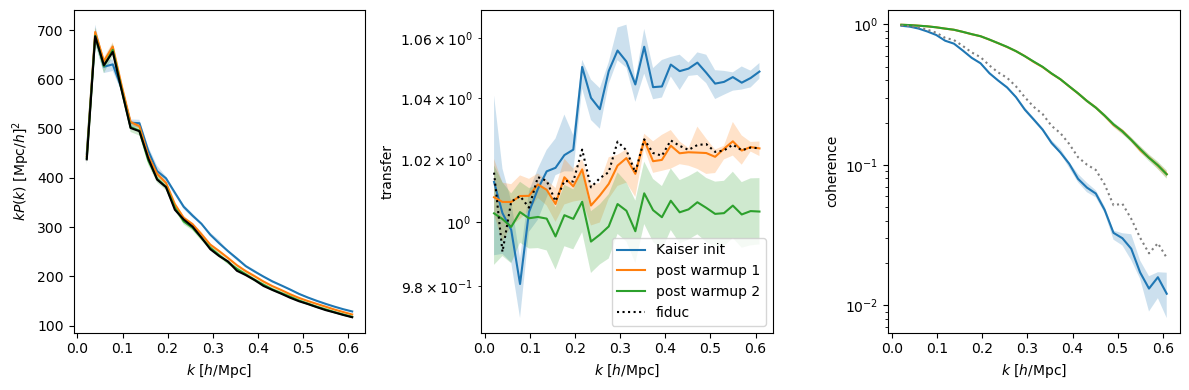

In [ ]:

prob = 0.95
plt.figure(figsize=(12, 4))
plot_powtranscoh(*jnp.median(jnp.stack(kptcs__), 1), label='Kaiser init')
plot_powtranscoh(*kptcs__, fill=prob)
plot_powtranscoh(*jnp.median(jnp.stack(kptcs_), 1), label='post warmup 1')
plot_powtranscoh(*kptcs_, fill=prob)
plot_powtranscoh(*jnp.median(jnp.stack(kptcs_last), 1), label='post warmup 2')
plot_powtranscoh(*kptcs_last, fill=prob)
plt.subplot(131)
plot_pow(*pow0, 'k', label='true')
plt.subplot(132)
plot_trans(*fiduc_trans, 'k:', label='fiduc')
# plot_pow(*kpkobs, ':', c='grey', label='obs')
plt.legend()
plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[-1], ':', c='grey', label='obs')
plt.tight_layout()
# plt.savefig(save_dir+f'initkai_{task_id}.png')
# plt.savefig(f'init_glin_{task_id}.png')
################    

## Anim

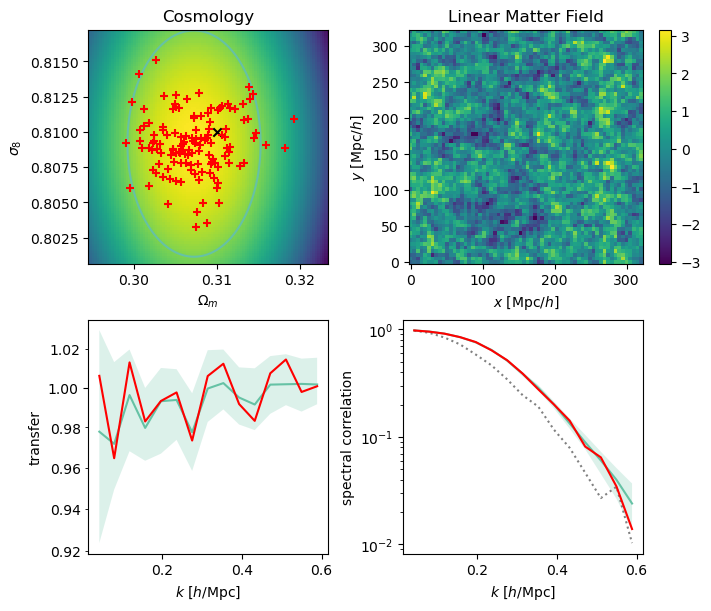

In [ ]:
from montecosmo.plot import plot_powtranscoh, plot_coh, plot_trans, plot_pow, plot_mesh, theme, mean_slice, plot_bivar
from montecosmo.utils import vlim
from sklearn.neighbors import KernelDensity
from matplotlib.animation import FuncAnimation
theme()

i_c = 0
i_plt = 10
sli = 0.1
log = False
prob = 0.95

plt.figure(figsize=(7, 6), layout='constrained')

plt.subplot(221)
xys = chains[i_c]['cosmo']
xy0 = Chains(truth, model.groups)['cosmo']
n_plt = len(xys[0])
lims = tree.map(partial(vlim, level=0.99, scale=1.5), xys)

kde = KernelDensity(kernel='gaussian', bandwidth='scott', atol=1e-5, rtol=1e-5)
xs = jnp.stack(xys).T
kde.fit(xs)
pdf = lambda x: jnp.exp(kde.score_samples(x))

# probs = np.array([0.68, 0.95, 0.997])
probs = np.array([0.95])
levels = jnp.quantile(pdf(xs), 1-probs[::-1])

plot_bivar(pdf, lims, n=100, type='mesh')
plot_bivar(pdf, lims, n=100, type='contour', colors=[SetDark2(0)], levels=levels, zorder=1)

xy = tree.map(lambda x: x[:i_plt], xys)
labels = [chains.labels[k] for k in chains.groups['cosmo']]

plt.scatter(*xy0, marker='x', color='k')
scat = plt.scatter(*xys, marker='+', color='r')
plt.xlabel(f'${labels[0]}$'), plt.ylabel(f'${labels[1]}$')
plt.xlim(lims[0]), plt.ylim(lims[1])
plt.title('Cosmology')


plt.subplot(222)
meshes = chains[i_c]['init']
mesh = meshes[i_plt]
quad1 = plot_mesh(mesh, model.box_shape, sli=sli)
plt.title('Linear Matter Field')
plt.colorbar()


# plt.subplot(233)
# # diff = mesh - mesh0
# # quad2 = plot_mesh(diff, model.box_shape, sli=sli, cmap='PRGn')
# stds = meshes.std(0)
# quad2 = plot_mesh(stds, model.box_shape, sli=sli, cmap='viridis')
# plt.title('Linear Matter Field std')
# plt.colorbar()


kptcs = chains[i_c]['kptc']
kptc_med = tree.map(lambda x: jnp.median(x, 0), kptcs)
kptc = tree.map(lambda x: x[i_plt], kptcs)

plt.subplot(223)

plot_trans(kptc_med[0], kptc_med[2])
plot_trans(kptcs[0], kptcs[2], fill=prob)

line1 = plot_trans(kptc[0], kptc[2], log=log, color='r')[0]
import matplotlib as mpl
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())


plt.subplot(224)
plot_coh(kptc_med[0], kptc_med[3])
plot_coh(kptcs[0], kptcs[3], fill=prob)
plot_coh(kptc_obs[0], kptc_obs[3], ':', log=log, c='grey', label='obs')

line2 = plot_coh(kptc[0], kptc[3], log=log, color='r')[0]
# plt.ylabel('$| R(\\delta_L, \\delta_L^{\\rm{true}})|$')
plt.ylabel('spectral correlation')




def update(i):
    xy = tree.map(lambda x: x[:i], xys)
    scat.set_offsets(jnp.stack(xy).T)

    mesh = meshes[i]
    mesh2d = mean_slice(mesh, sli)
    quad1.set_array(mesh2d)
    # diff2d = mean_slice(mesh - mesh0, sli)
    # quad2.set_array(diff2d)

    kptc = tree.map(lambda x: x[i], kptcs)
    ks, pow, trans, coh = kptc
    # if not log:
    #     pow *= ks
    line1.set_data(ks, trans)
    line2.set_data(ks, coh)

    return scat, quad1, line1, line2

display(plt.gcf())
anim = FuncAnimation(plt.gcf(), update, frames=n_plt, interval=100, repeat_delay=1000, blit=True)
# anim.save("anim_chains.mp4")
display(anim)
plt.close()

## Plot

In [3]:
from montecosmo.mcbench import Chains
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_trans, plot_coh, theme, SetDark2

save_dir = '/feynman/home/dphp/hs276503/scratch/pickles/evolution/m128_b640.0_ao0.5_evlpt_lo2_pckaiser_dyn_obfield/'
save_path = save_dir + 'sMCLMC_nc8_ns32'

# Load truth
print(f"Loading truth from {save_dir}")
truth = pload(save_dir+"truth.p")
model = FieldLevelModel.load(save_dir+"model.p")
mesh0 = jnp.fft.irfftn(truth['init_mesh'])
pow0 = model.spectrum(mesh0)
kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)

chlin = pload(save_path+'_chains_meshlinz5.p')
chobs = pload(save_path+'_chains_meshobsz5.p')
chbias = pload(save_path+'_chains_meshbias5.p')
chgxy = pload(save_path+'_chains_meshgxy5.p')
chgxytrue = pload(save_path+'_chains_meshgxytrue5.p')
chlin.shape, chobs.shape, chbias.shape, chgxy.shape, chgxytrue.shape

Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/evolution/m128_b640.0_ao0.5_evlpt_lo2_pckaiser_dyn_obfield/


({'Omega_m': (8, 1920),
  'b1': (8, 1920),
  'b2': (8, 1920),
  'bn2': (8, 1920),
  'bs2': (8, 1920),
  'init_mesh': (8, 1920, 128, 128),
  'kptc': ((8, 1920, 31), (8, 1920, 31), (8, 1920, 31), (8, 1920, 31)),
  'mse_per_dim': (8, 1920),
  'n_evals': (8, 1920),
  'sigma8': (8, 1920)},
 {'kptc': ((8, 960, 31), (8, 960, 31), (8, 960, 31), (8, 960, 31)),
  'obs': (8, 960, 128, 128)},
 {'bias_mesh': (8, 960, 128, 128),
  'kptc': ((8, 960, 31), (8, 960, 31), (8, 960, 31), (8, 960, 31))},
 {'gxy_mesh': (8, 960, 128, 128),
  'kptc': ((8, 960, 31), (8, 960, 31), (8, 960, 31), (8, 960, 31))},
 {'gxy_mesh': (8, 960, 128, 128),
  'kptc': ((8, 960, 31), (8, 960, 31), (8, 960, 31), (8, 960, 31))})

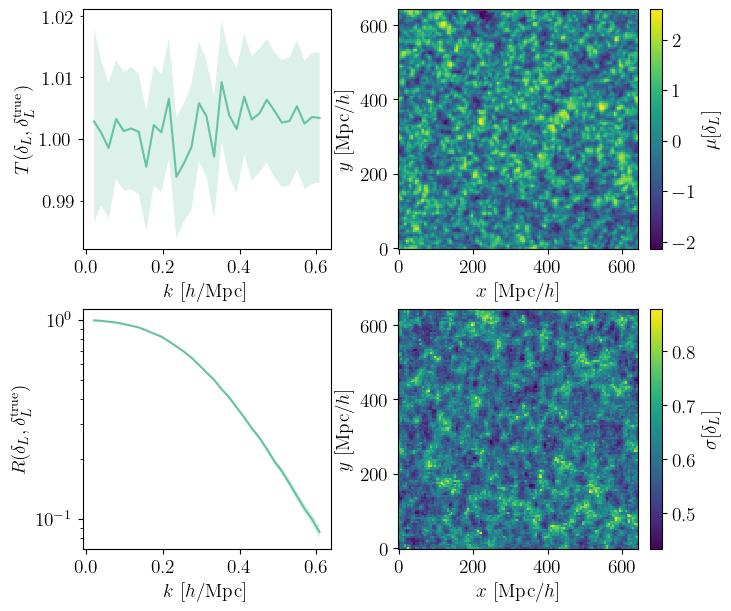

In [4]:
from montecosmo.plot import plot_powtranscoh, plot_coh, plot_trans, plot_pow, plot_mesh, theme, mean_slice, plot_bivar
from montecosmo.utils import vlim
from sklearn.neighbors import KernelDensity
from matplotlib.animation import FuncAnimation
theme(usetex=True, font_size=14)

sli = 1
log = False
prob = 0.95
meshes = jnp.concatenate(chlin['init'])

plt.figure(figsize=(7.2, 6), layout='constrained')
# plt.figure(figsize=(7.5, 6))
# plt.subplots_adjust(wspace=.3, hspace=0.3)

plt.subplot(222)
means = meshes.mean(0)[...,None]
# means = jnp.median(meshes, axis=0)[...,None]
quad2 = plot_mesh(means, model.box_shape, sli=sli, cmap='viridis')
# plt.title('post mean')
# plt.colorbar(label='mean')
# plt.colorbar(label='$\\mu(\\delta_L)$')
plt.colorbar(label='$\\mu[\\delta_L]$')


plt.subplot(224)
stds = meshes.std(0)[...,None]
quad2 = plot_mesh(stds, model.box_shape, sli=sli, cmap='viridis')
# plt.title('post std')
# plt.colorbar(label='std')
plt.colorbar(label='$\\sigma[\\delta_L]$')

kptcs = tree.map(jnp.concatenate, chlin['kptc'])
kptc_med = tree.map(lambda x: jnp.median(x, 0), kptcs)

plt.subplot(221)

plot_trans(kptc_med[0], kptc_med[2])
plot_trans(kptcs[0], kptcs[2], fill=prob)
plt.ylabel('$T(\\delta_L, \\delta_L^\\mathrm{true})$')
# plt.ylabel('$T(\\delta_L, \\delta_L^\\mathrm{true})$')

import matplotlib as mpl
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(4))
plt.gca().yaxis.set_minor_locator(mpl.ticker.MaxNLocator(4))


plt.subplot(223)
plot_coh(kptc_med[0], kptc_med[3])
plot_coh(kptcs[0], kptcs[3], fill=prob)
# plot_coh(kptc_obs[0], kptc_obs[3], ':', log=log, c='grey', label='obs')

# plt.ylabel('$| R(\\delta_L, \\delta_L^{\\rm{true}})|$')
# plt.ylabel('spectral correlation');
plt.ylabel('$R(\\delta_L, \\delta_L^\\mathrm{true})$')
# plt.ylabel('$R(\\delta_L , \\delta_L^\\mathrm{true}) \\mid \\delta_g$')
# plt.ylabel('$R(\\delta_L, \\delta_L^\\mathrm{true})$')
plt.savefig(f'post_linfieldz5.pdf', bbox_inches='tight')
plt.savefig(f'post_linfieldz5.png', dpi=300, bbox_inches='tight')

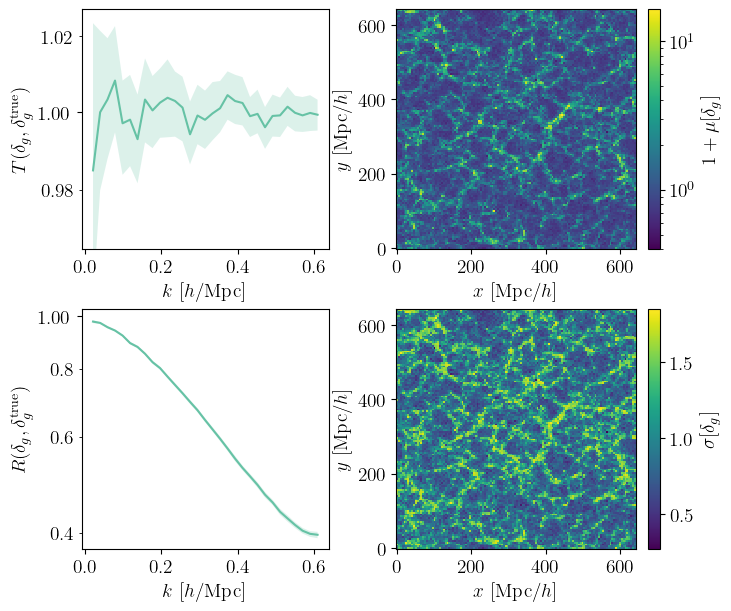

In [9]:
from montecosmo.plot import plot_powtranscoh, plot_coh, plot_trans, plot_pow, plot_mesh, theme, mean_slice, plot_bivar
from montecosmo.utils import vlim
from sklearn.neighbors import KernelDensity
from matplotlib.animation import FuncAnimation
theme(usetex=True, font_size=14)

sli = 1
log = False
prob = 0.95
# meshes = jnp.concatenate(chbias['bias_mesh'])
meshes = jnp.concatenate(chobs['obs'])
# meshes = jnp.concatenate(chgxy['gxy_mesh'])
# meshes = jnp.concatenate(chgxytrue['gxy_mesh'])

plt.figure(figsize=(7.2, 6), layout='constrained')
# plt.figure(figsize=(7, 6))
# plt.subplots_adjust(wspace=.3, hspace=0.3)

plt.subplot(222)
vmin = 0.4
# meshes = jnp.maximum(meshes + 1, vmin)
meshes = jnp.maximum(meshes, vmin)
means = meshes.mean(0)[...,None]
vmax = np.quantile(means, [1-1e-4/2])
quad2 = plot_mesh(means, model.box_shape, sli=sli, cmap='viridis', vlim=(vmin,vmax), norm='log')
# quad2 = plot_mesh(means, model.box_shape, sli=sli, cmap='viridis')
# plt.title('post mean')
# plt.colorbar(label='mean')
plt.colorbar(label='$1 + \\mu[\\delta_g]$')
# plt.colorbar(label='$\\mu[1+\\delta_g \\mid \\delta_g]$')


plt.subplot(224)
stds = meshes.std(0)[...,None]
vmax = np.quantile(stds, [1-1e-4/2])
# quad2 = plot_mesh(stds, model.box_shape, sli=sli, cmap='viridis', vlim=(vmin,vmax), norm='log')
quad2 = plot_mesh(stds, model.box_shape, sli=sli, cmap='viridis')
# plt.title('post std')
# plt.colorbar(label='std')
plt.colorbar(label='$\\sigma[\\delta_g]$')

# kptcs = tree.map(jnp.concatenate, chbias['kptc'])
kptcs = tree.map(jnp.concatenate, chobs['kptc'])
# kptcs = tree.map(jnp.concatenate, chgxy['kptc'])
# kptcs = tree.map(jnp.concatenate, chgxytrue['kptc'])
kptc_med = tree.map(lambda x: jnp.median(x, 0), kptcs)

plt.subplot(221)

plot_trans(kptc_med[0], kptc_med[2])
plot_trans(kptcs[0], kptcs[2], fill=prob)
plt.ylabel('$T(\\delta_g, \\delta_g^\\mathrm{true})$')
plt.ylim(0.965, plt.ylim()[1])
# plt.ylabel('$T(\\delta_L, \\delta_L^\\textrm{true})$')

import matplotlib as mpl
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(4))
plt.gca().yaxis.set_minor_locator(mpl.ticker.MaxNLocator(4))


plt.subplot(223)
plot_coh(kptc_med[0], kptc_med[3])
plot_coh(kptcs[0], kptcs[3], fill=prob)
# plot_coh(kptc_obs[0], kptc_obs[3], ':', log=log, c='grey', label='obs')

# plt.ylabel('$| R(\\delta_L, \\delta_L^{\\rm{true}})|$')
# plt.ylabel('spectral correlation');
plt.ylabel('$R(\\delta_g, \\delta_g^\\mathrm{true})$')

import matplotlib as mpl
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(4))
plt.gca().yaxis.set_minor_locator(mpl.ticker.MaxNLocator(4))
# plt.savefig(f'post_gxyfield5.pdf', bbox_inches='tight')
# plt.savefig(f'post_gxyfield5.png', dpi=300, bbox_inches='tight')
# # plt.savefig(f'post_gxytruefield5.pdf', bbox_inches='tight')
# plt.savefig(f'post_gxytruefield5.png', dpi=300, bbox_inches='tight')
plt.savefig(f'post_obsfieldz5.pdf', bbox_inches='tight')
plt.savefig(f'post_obsfield5z.png', dpi=300, bbox_inches='tight')

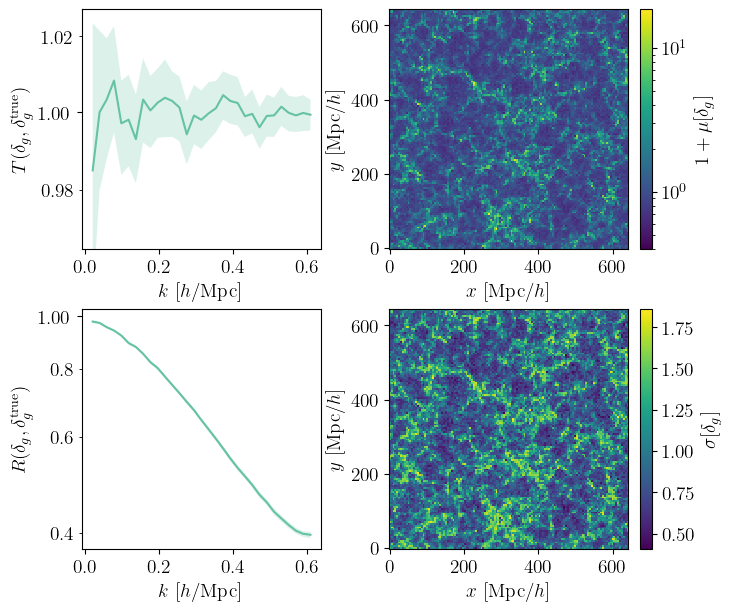

In [ ]:
from montecosmo.plot import plot_powtranscoh, plot_coh, plot_trans, plot_pow, plot_mesh, theme, mean_slice, plot_bivar
from montecosmo.utils import vlim
from sklearn.neighbors import KernelDensity
from matplotlib.animation import FuncAnimation
theme(usetex=True, font_size=14)

sli = 1
log = False
prob = 0.95
# meshes = jnp.concatenate(chbias['bias_mesh'])
meshes = jnp.concatenate(chobs['obs'])
# meshes = jnp.concatenate(chgxy['gxy_mesh'])
# meshes = jnp.concatenate(chgxytrue['gxy_mesh'])

plt.figure(figsize=(7.2, 6), layout='constrained')
# plt.figure(figsize=(7, 6))
# plt.subplots_adjust(wspace=.3, hspace=0.3)

plt.subplot(222)
vmin = 0.4
# meshes = jnp.maximum(meshes + 1, vmin)
meshes = jnp.maximum(meshes, vmin)
means = meshes.mean(0)[...,None]
vmax = np.quantile(means, [1-1e-4/2])
quad2 = plot_mesh(means, model.box_shape, sli=sli, cmap='viridis', vlim=(vmin,vmax), norm='log')
# quad2 = plot_mesh(means, model.box_shape, sli=sli, cmap='viridis')
# plt.title('post mean')
# plt.colorbar(label='mean')
plt.colorbar(label='$1 + \\mu[\\delta_g]$')
# plt.colorbar(label='$\\mu[1+\\delta_g \\mid \\delta_g]$')


plt.subplot(224)
stds = meshes.std(0)[...,None]
vmax = np.quantile(stds, [1-1e-4/2])
# quad2 = plot_mesh(stds, model.box_shape, sli=sli, cmap='viridis', vlim=(vmin,vmax), norm='log')
quad2 = plot_mesh(stds, model.box_shape, sli=sli, cmap='viridis')
# plt.title('post std')
# plt.colorbar(label='std')
plt.colorbar(label='$\\sigma[\\delta_g]$')

# kptcs = tree.map(jnp.concatenate, chbias['kptc'])
kptcs = tree.map(jnp.concatenate, chobs['kptc'])
# kptcs = tree.map(jnp.concatenate, chgxy['kptc'])
# kptcs = tree.map(jnp.concatenate, chgxytrue['kptc'])
kptc_med = tree.map(lambda x: jnp.median(x, 0), kptcs)

plt.subplot(221)

plot_trans(kptc_med[0], kptc_med[2])
plot_trans(kptcs[0], kptcs[2], fill=prob)
plt.ylabel('$T(\\delta_g, \\delta_g^\\mathrm{true})$')
plt.ylim(0.965, plt.ylim()[1])
# plt.ylabel('$T(\\delta_L, \\delta_L^\\textrm{true})$')

import matplotlib as mpl
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(4))
plt.gca().yaxis.set_minor_locator(mpl.ticker.MaxNLocator(4))


plt.subplot(223)
plot_coh(kptc_med[0], kptc_med[3])
plot_coh(kptcs[0], kptcs[3], fill=prob)
# plot_coh(kptc_obs[0], kptc_obs[3], ':', log=log, c='grey', label='obs')

# plt.ylabel('$| R(\\delta_L, \\delta_L^{\\rm{true}})|$')
# plt.ylabel('spectral correlation');
plt.ylabel('$R(\\delta_g, \\delta_g^\\mathrm{true})$')

import matplotlib as mpl
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(4))
plt.gca().yaxis.set_minor_locator(mpl.ticker.MaxNLocator(4))
# plt.savefig(f'post_gxyfield5.pdf', bbox_inches='tight')
# plt.savefig(f'post_gxyfield5.png', dpi=300, bbox_inches='tight')
# # plt.savefig(f'post_gxytruefield5.pdf', bbox_inches='tight')
# plt.savefig(f'post_gxytruefield5.png', dpi=300, bbox_inches='tight')
plt.savefig(f'post_obsfieldz5.pdf', bbox_inches='tight')
plt.savefig(f'post_obsfield5z.png', dpi=300, bbox_inches='tight')